✅ File loaded successfully!

--- Starting Feature Engineering ---
✅ Feature Engineering complete.

--- Creating Targets and Splitting Data ---
Training data shape: (6973, 31)
Testing data shape: (1744, 31)

--- Training and Evaluating Models ---

Training model for: temp_target_1hr
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000164 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4140
[LightGBM] [Info] Number of data points in the train set: 6973, number of used features: 31
[LightGBM] [Info] Start training from score 24.726966


C:\Users\minht\AppData\Local\Temp\ipykernel_52732\519617538.py:15: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['DateTime'] = pd.to_datetime(df['DateTime'])
C:\Users\minht\AppData\Local\Temp\ipykernel_52732\519617538.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['rain volumn (mm)'].fillna(0, inplace=True)


Results for temp_target_1hr:
  Mean Absolute Error (MAE): 0.521 °C
  Root Mean Squared Error (RMSE): 0.747 °C
  R-squared (R2): 0.970


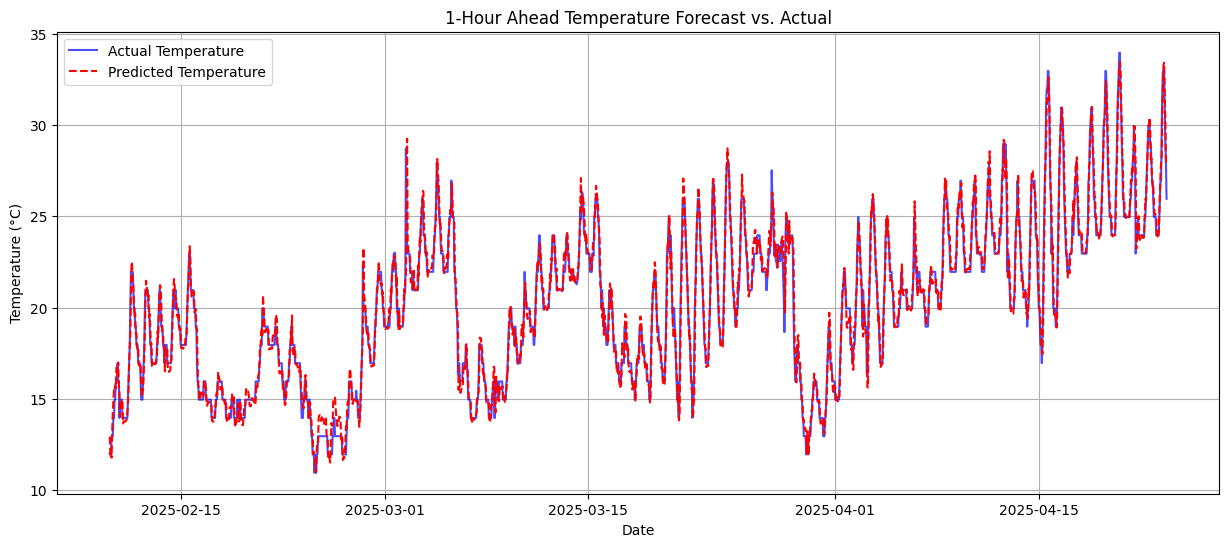


Training model for: temp_target_2hr
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000600 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4140
[LightGBM] [Info] Number of data points in the train set: 6973, number of used features: 31
[LightGBM] [Info] Start training from score 24.725245
Results for temp_target_2hr:
  Mean Absolute Error (MAE): 0.758 °C
  Root Mean Squared Error (RMSE): 1.035 °C
  R-squared (R2): 0.943

Training model for: temp_target_3hr
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000657 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4140
[LightGBM] [Info] Number of data points in the train set: 6973, number of used features: 31
[L

In [2]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load and Clean Data ---
try:
    df = pd.read_csv('Hanoi_Weather_Data.csv')
    print("✅ File loaded successfully!")

    # Basic cleaning from our EDA
    df['DateTime'] = pd.to_datetime(df['DateTime'])
    df['rain volumn (mm)'].fillna(0, inplace=True)
    df.drop(columns=['sea level pressure', 'grnd level pressure', 'snow volumn (mm)', 'icon id', 
                     'weather main', 'weather description'], inplace=True)
    df.set_index('DateTime', inplace=True)
    
    # Sort index to ensure chronological order
    df.sort_index(inplace=True)

except FileNotFoundError:
    print("❌ Error: 'Hanoi_Weather_Data.csv' not found.")
    exit()


# --- 2. Feature Engineering ---
print("\n--- Starting Feature Engineering ---")

# We create features based on past data (lags)
for lag in range(1, 7): # Use data from the past 6 hours
    df[f'temp_lag_{lag}'] = df['Temperature (C)'].shift(lag)
    df[f'humidity_lag_{lag}'] = df['Humidity %'].shift(lag)
    df[f'wind_speed_lag_{lag}'] = df['wind speed (m/s)'].shift(lag)

# We create rolling window features
df['temp_rolling_mean_3'] = df['Temperature (C)'].shift(1).rolling(window=3).mean()
df['temp_rolling_mean_6'] = df['Temperature (C)'].shift(1).rolling(window=6).mean()

# Time-based features
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek

print("✅ Feature Engineering complete.")


# --- 3. Create Target Variables and Split Data ---
print("\n--- Creating Targets and Splitting Data ---")
# The target is the temperature in the future. We want to predict 1, 2, 3, 4, and 5 hours ahead.
for i in range(1, 6):
    df[f'temp_target_{i}hr'] = df['Temperature (C)'].shift(-i)

# Drop rows with NaN values created by shifts and rolling windows
df.dropna(inplace=True)

# Our features (X) are all columns except the targets
features = [col for col in df.columns if 'target' not in col]
X = df[features]

# We will create 5 separate models, one for each forecast hour (target)
targets = [f'temp_target_{i}hr' for i in range(1, 6)]

# Time-series split: Train on the first 80%, test on the last 20%
train_size = int(len(df) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")


# --- 4. Train Models and Evaluate ---
print("\n--- Training and Evaluating Models ---")
evaluation_results = {}

for target in targets:
    print(f"\nTraining model for: {target}")
    
    # Get the corresponding target data for train and test sets
    y = df[target]
    y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
    
    # Initialize and train the LightGBM Regressor model
    model = lgb.LGBMRegressor(random_state=42)
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    predictions = model.predict(X_test)
    
    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    r2 = r2_score(y_test, predictions)
    
    evaluation_results[target] = {'MAE': mae, 'RMSE': rmse, 'R2': r2}
    
    print(f"Results for {target}:")
    print(f"  Mean Absolute Error (MAE): {mae:.3f} °C")
    print(f"  Root Mean Squared Error (RMSE): {rmse:.3f} °C")
    print(f"  R-squared (R2): {r2:.3f}")

    # --- 5. Visualize Results (for the first model) ---
    if target == 'temp_target_1hr':
        plt.figure(figsize=(15, 6))
        plt.plot(y_test.index, y_test, label='Actual Temperature', color='blue', alpha=0.7)
        plt.plot(y_test.index, predictions, label='Predicted Temperature', color='red', linestyle='--')
        plt.title('1-Hour Ahead Temperature Forecast vs. Actual')
        plt.xlabel('Date')
        plt.ylabel('Temperature (°C)')
        plt.legend()
        plt.grid(True)
        plt.show()

print("\n\n✅ Modeling process finished.")

# Display final results in a DataFrame
results_df = pd.DataFrame(evaluation_results).T
print("\n--- Summary of Evaluation Results ---")
print(results_df)

In [4]:
# --- Import Necessary Libraries ---
import pandas as pd
import numpy as np
import lightgbm as lgb
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    recall_score,

    precision_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

# ==============================================================================
# 1. DATA PREPARATION
# ==============================================================================

def prepare_data(file_path='Hanoi_Weather_Data.csv'):
    """
    Loads, cleans, and engineers features for the weather dataset.
    """
    try:
        df = pd.read_csv(file_path)
        print("✅ File loaded successfully!")
    except FileNotFoundError:
        print(f"❌ Error: The file '{file_path}' was not found.")
        return None

    # --- Basic Cleaning ---
    df['DateTime'] = pd.to_datetime(df['DateTime'])
    df['rain volumn (mm)'].fillna(0, inplace=True)
    df.drop(columns=['sea level pressure', 'grnd level pressure', 'snow volumn (mm)', 'icon id',
                     'weather main', 'weather description'], inplace=True)
    df.set_index('DateTime', inplace=True)
    df.sort_index(inplace=True)
    df['Rain Event'] = (df['rain volumn (mm)'] > 0).astype(int)

    # --- Feature Engineering ---
    print("--- Engineering features (lags and rolling stats)...")
    for lag in range(1, 7):
        df[f'temp_lag_{lag}'] = df['Temperature (C)'].shift(lag)
        df[f'humidity_lag_{lag}'] = df['Humidity %'].shift(lag)
        df[f'wind_speed_lag_{lag}'] = df['wind speed (m/s)'].shift(lag)
        df[f'rain_vol_lag_{lag}'] = df['rain volumn (mm)'].shift(lag)

    df['temp_rolling_mean_6'] = df['Temperature (C)'].shift(1).rolling(window=6).mean()
    df['humidity_rolling_mean_6'] = df['Humidity %'].shift(1).rolling(window=6).mean()

    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    print("✅ Feature engineering complete.")
    
    return df

# ==============================================================================
# 2. TEMPERATURE FORECASTING MODEL
# ==============================================================================

def train_temperature_models(df):
    """
    Trains, evaluates, and saves 5 models for temperature forecasting.
    """
    print("\n" + "="*50)
    print("  TEMPERATURE FORECASTING (5-HOUR)")
    print("="*50)

    # --- Create Targets and Split Data ---
    for i in range(1, 6):
        df[f'temp_target_{i}hr'] = df['Temperature (C)'].shift(-i)

    df_temp = df.copy().dropna()

    features = [col for col in df_temp.columns if 'target' not in col and 'Rain Event' not in col and 'rain volumn (mm)' not in col]
    X = df_temp[features]
    targets = [f'temp_target_{i}hr' for i in range(1, 6)]

    train_size = int(len(df_temp) * 0.8)
    X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]

    # --- Train and Evaluate ---
    evaluation_results = {}
    for target in targets:
        print(f"\n--- Training model for: {target} ---")
        y = df_temp[target]
        y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

        model = lgb.LGBMRegressor(random_state=42)
        model.fit(X_train, y_train)

        # --- Save the Model ---
        model_filename = f'temp_forecast_{target}.joblib'
        joblib.dump(model, model_filename)
        print(f"✅ Model saved as '{model_filename}'")

        predictions = model.predict(X_test)
        mae = mean_absolute_error(y_test, predictions)
        rmse = np.sqrt(mean_squared_error(y_test, predictions))
        r2 = r2_score(y_test, predictions)
        evaluation_results[target] = {'MAE': mae, 'RMSE': rmse, 'R2': r2}

    # --- Display Results ---
    results_df = pd.DataFrame(evaluation_results).T
    print("\n--- Summary of Temperature Model Evaluation ---")
    print(results_df)
    return results_df

# ==============================================================================
# 3. RAIN PROBABILITY FORECASTING MODEL
# ==============================================================================

def train_rain_models(df):
    """
    Trains, evaluates, and saves 5 models for rain probability forecasting.
    """
    print("\n" + "="*50)
    print("    RAIN PROBABILITY FORECASTING (5-HOUR)")
    print("="*50)

    # --- Create Targets and Split Data ---
    for i in range(1, 6):
        df[f'rain_target_{i}hr'] = df['Rain Event'].shift(-i)

    df_rain = df.copy().dropna()
    
    features = [col for col in df_rain.columns if 'target' not in col and 'Rain Event' not in col and 'rain volumn (mm)' not in col and 'Temperature (C)' not in col]
    X = df_rain[features]
    targets = [f'rain_target_{i}hr' for i in range(1, 6)]
    
    train_size = int(len(df_rain) * 0.8)
    X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]

    # --- Train and Evaluate ---
    evaluation_results = {}
    for target in targets:
        print(f"\n--- Training model for: {target} ---")
        y = df_rain[target]
        y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

        scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum() if (y_train == 1).sum() > 0 else 1

        model = lgb.LGBMClassifier(random_state=42, scale_pos_weight=scale_pos_weight)
        model.fit(X_train, y_train)
        
        # --- Save the Model ---
        model_filename = f'rain_forecast_{target}.joblib'
        joblib.dump(model, model_filename)
        print(f"✅ Model saved as '{model_filename}'")

        predictions_proba = model.predict_proba(X_test)[:, 1]
        predictions = model.predict(X_test)

        recall = recall_score(y_test, predictions)
        precision = precision_score(y_test, predictions)
        f1 = f1_score(y_test, predictions)
        auc = roc_auc_score(y_test, predictions_proba)
        evaluation_results[target] = {'Recall': recall, 'Precision': precision, 'F1-Score': f1, 'AUC': auc}

    # --- Display Results ---
    results_df = pd.DataFrame(evaluation_results).T
    print("\n--- Summary of Rain Model Evaluation ---")
    print(results_df)
    return results_df

# ==============================================================================
# 4. MAIN EXECUTION
# ==============================================================================

if __name__ == '__main__':
    # Prepare the data once
    master_df = prepare_data()

    if master_df is not None:
        # Run the temperature modeling pipeline
        train_temperature_models(master_df.copy()) # Use a copy to avoid data leakage

        # Run the rain modeling pipeline
        train_rain_models(master_df.copy()) # Use another copy

        print("\n\n✅ All models have been trained, evaluated, and saved successfully.")

✅ File loaded successfully!
--- Engineering features (lags and rolling stats)...
✅ Feature engineering complete.

  TEMPERATURE FORECASTING (5-HOUR)

--- Training model for: temp_target_1hr ---
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000629 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4989
[LightGBM] [Info] Number of data points in the train set: 6973, number of used features: 36
[LightGBM] [Info] Start training from score 24.726966
✅ Model saved as 'temp_forecast_temp_target_1hr.joblib'

--- Training model for: temp_target_2hr ---
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000648 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4989
[LightG

✅ Data prepared successfully.

--- Training the 1-hour rain forecast model ---
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1265, number of negative: 5711
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000727 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4725
[LightGBM] [Info] Number of data points in the train set: 6976, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181336 -> initscore=-1.507322
[LightGBM] [Info] Start training from score -1.507322
✅ Model training complete.

--- Testing different thresholds to find the best balance ---

--- Generating Recall vs. Precision plot ---


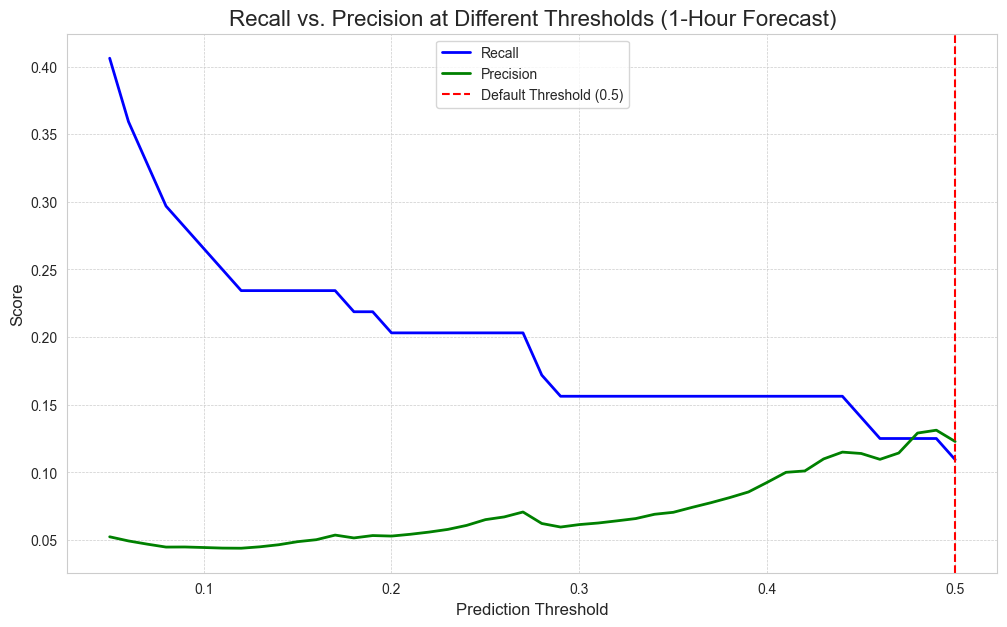

In [5]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load, Clean, and Prepare Data ---
# (Using the same data preparation steps as the last script)
try:
    df = pd.read_csv('Hanoi_Weather_Data.csv')
    df['DateTime'] = pd.to_datetime(df['DateTime'])
    df['rain volumn (mm)'].fillna(0, inplace=True)
    df.drop(columns=['sea level pressure', 'grnd level pressure', 'snow volumn (mm)', 'icon id',
                     'weather main', 'weather description'], inplace=True)
    df.set_index('DateTime', inplace=True)
    df.sort_index(inplace=True)
    df['Rain Event'] = (df['rain volumn (mm)'] > 0).astype(int)
    for lag in range(1, 7):
        df[f'temp_lag_{lag}'] = df['Temperature (C)'].shift(lag)
        df[f'humidity_lag_{lag}'] = df['Humidity %'].shift(lag)
        df[f'wind_speed_lag_{lag}'] = df['wind speed (m/s)'].shift(lag)
        df[f'rain_vol_lag_{lag}'] = df['rain volumn (mm)'].shift(lag)
    df['humidity_rolling_mean_6'] = df['Humidity %'].shift(1).rolling(window=6).mean()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['rain_target_1hr'] = df['Rain Event'].shift(-1)
    df.dropna(inplace=True)
    
    features = [col for col in df.columns if 'target' not in col and 'Rain Event' not in col and 'rain volumn (mm)' not in col and 'Temperature (C)' not in col]
    X = df[features]
    y = df['rain_target_1hr']
    
    train_size = int(len(df) * 0.8)
    X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
    y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
    
    print("✅ Data prepared successfully.")
except Exception as e:
    print(f"An error occurred during data prep: {e}")
    exit()

# --- 2. Train the 1-Hour Rain Forecast Model ---
print("\n--- Training the 1-hour rain forecast model ---")
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
model = lgb.LGBMClassifier(random_state=42, scale_pos_weight=scale_pos_weight)
model.fit(X_train, y_train)
print("✅ Model training complete.")

# --- 3. Find the Optimal Threshold ---
print("\n--- Testing different thresholds to find the best balance ---")
# Get the predicted probabilities for the 'Rain' class
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Define a range of thresholds to test
thresholds = np.arange(0.05, 0.51, 0.01)
recalls = []
precisions = []

for thresh in thresholds:
    # Apply the threshold to the probabilities to get the final predictions
    y_pred_thresholded = (y_pred_proba >= thresh).astype(int)
    
    # Calculate recall and precision for this threshold
    recalls.append(recall_score(y_test, y_pred_thresholded))
    precisions.append(precision_score(y_test, y_pred_thresholded, zero_division=0))

# --- 4. Plot the Results ---
print("\n--- Generating Recall vs. Precision plot ---")
plt.figure(figsize=(12, 7))
plt.plot(thresholds, recalls, label='Recall', color='blue', linewidth=2)
plt.plot(thresholds, precisions, label='Precision', color='green', linewidth=2)
plt.title('Recall vs. Precision at Different Thresholds (1-Hour Forecast)', fontsize=16)
plt.xlabel('Prediction Threshold', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
# Add a vertical line at the default 0.5 threshold for comparison
plt.axvline(x=0.5, color='red', linestyle='--', label='Default Threshold (0.5)')
plt.legend()
plt.show()

# SMOTE

✅ Data prepared and split successfully.
Original training data shape: (6976, 25)
Original number of 'Rain' events in training data: 1265

--- Applying SMOTE to balance the training data ---
✅ SMOTE applied successfully.
Resampled training data shape: (11422, 25)
Number of 'Rain' events in resampled training data: 5711

--- Training model on the new, balanced data ---
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5711, number of negative: 5711
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000940 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5827
[LightGBM] [Info] Number of data points in the train set: 11422, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

--- Evaluation Results on the Test Set ---


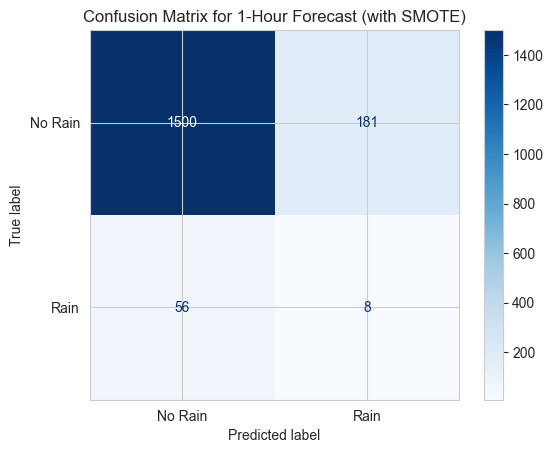


--- Summary of Evaluation Results ---
   Recall  Precision  F1-Score       AUC
0   0.125   0.042328  0.063241  0.526022


In [6]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import (
    recall_score, 
    precision_score, 
    f1_score, 
    roc_auc_score, 
    confusion_matrix,
    ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

# --- 1. Load and Prepare Data ---
try:
    df = pd.read_csv('Hanoi_Weather_Data.csv')
    # (Same data loading and feature engineering as before)
    df['DateTime'] = pd.to_datetime(df['DateTime'])
    df['rain volumn (mm)'].fillna(0, inplace=True)
    df.drop(columns=['sea level pressure', 'grnd level pressure', 'snow volumn (mm)', 'icon id', 
                     'weather main', 'weather description'], inplace=True)
    df.set_index('DateTime', inplace=True)
    df.sort_index(inplace=True)
    df['Rain Event'] = (df['rain volumn (mm)'] > 0).astype(int)
    for lag in range(1, 7):
        df[f'temp_lag_{lag}'] = df['Temperature (C)'].shift(lag)
        df[f'humidity_lag_{lag}'] = df['Humidity %'].shift(lag)
        df[f'wind_speed_lag_{lag}'] = df['wind speed (m/s)'].shift(lag)
    df['rain_target_1hr'] = df['Rain Event'].shift(-1)
    df.dropna(inplace=True)
    
    features = [col for col in df.columns if 'target' not in col and 'Rain Event' not in col and 'rain volumn (mm)' not in col and 'Temperature (C)' not in col]
    X = df[features]
    y = df['rain_target_1hr']
    
    # --- 2. Split Data BEFORE Applying SMOTE ---
    train_size = int(len(df) * 0.8)
    X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
    y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
    
    print("✅ Data prepared and split successfully.")
    print(f"Original training data shape: {X_train.shape}")
    print(f"Original number of 'Rain' events in training data: {(y_train == 1).sum()}")

except Exception as e:
    print(f"An error occurred during data prep: {e}")
    exit()

# --- 3. Apply SMOTE to the Training Data ---
print("\n--- Applying SMOTE to balance the training data ---")
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("✅ SMOTE applied successfully.")
print(f"Resampled training data shape: {X_train_resampled.shape}")
print(f"Number of 'Rain' events in resampled training data: {(y_train_resampled == 1).sum()}")


# --- 4. Train and Evaluate the Model ---
print("\n--- Training model on the new, balanced data ---")

# We no longer need scale_pos_weight because SMOTE has balanced the data
model = lgb.LGBMClassifier(random_state=42)

# IMPORTANT: Train on the resampled data
model.fit(X_train_resampled, y_train_resampled)

# IMPORTANT: Evaluate on the original, untouched test data
predictions = model.predict(X_test)
predictions_proba = model.predict_proba(X_test)[:, 1]

print("\n--- Evaluation Results on the Test Set ---")
recall = recall_score(y_test, predictions)
precision = precision_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
auc = roc_auc_score(y_test, predictions_proba)

# Display Confusion Matrix
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Rain', 'Rain'])
disp.plot(cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix for 1-Hour Forecast (with SMOTE)')
plt.show()

# Display Summary Table
results = {'Recall': recall, 'Precision': precision, 'F1-Score': f1, 'AUC': auc}
results_df = pd.DataFrame([results])
print("\n--- Summary of Evaluation Results ---")
print(results_df)

# NO SMOTE

In [7]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score
import warnings

warnings.filterwarnings('ignore')

# --- 1. Load and Prepare Data ---
try:
    df = pd.read_csv('Hanoi_Weather_Data.csv')
    # (Same data loading and feature engineering as before)
    df['DateTime'] = pd.to_datetime(df['DateTime'])
    df['rain volumn (mm)'].fillna(0, inplace=True)
    df.drop(columns=['sea level pressure', 'grnd level pressure', 'snow volumn (mm)', 'icon id', 
                     'weather main', 'weather description'], inplace=True)
    df.set_index('DateTime', inplace=True)
    df.sort_index(inplace=True)
    df['Rain Event'] = (df['rain volumn (mm)'] > 0).astype(int)
    for lag in range(1, 7):
        df[f'temp_lag_{lag}'] = df['Temperature (C)'].shift(lag)
        df[f'humidity_lag_{lag}'] = df['Humidity %'].shift(lag)
    
    print("✅ Data prepared successfully.")
except Exception as e:
    print(f"An error occurred during data prep: {e}")
    exit()

# --- 2. Train, Optimize, and Evaluate Models ---
print("\n--- Training, Optimizing, and Saving Final Rain Models ---")

final_results = []

targets = [f'rain_target_{i}hr' for i in range(1, 6)]
for i in range(1, 6):
    df[f'rain_target_{i}hr'] = df['Rain Event'].shift(-i)

df.dropna(inplace=True)

for target in targets:
    print(f"\n--- Processing model for: {target} ---")
    
    features = [col for col in df.columns if 'target' not in col and 'Rain Event' not in col and 'rain volumn (mm)' not in col and 'Temperature (C)' not in col]
    X = df[features]
    y = df[target]
    
    train_size = int(len(df) * 0.8)
    X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
    y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
    
    # Train the model
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
    model = lgb.LGBMClassifier(random_state=42, scale_pos_weight=scale_pos_weight)
    model.fit(X_train, y_train)
    
    # Save the final model
    model_filename = f'rain_forecast_optimized_{target}.joblib'
    joblib.dump(model, model_filename)
    print(f"✅ Model saved as '{model_filename}'")
    
    # Get probabilities on the test set
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # --- Find Optimal Threshold that Maximizes F1-Score ---
    thresholds = np.arange(0.05, 0.51, 0.01)
    f1_scores = [f1_score(y_test, (y_pred_proba >= t).astype(int)) for t in thresholds]
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    print(f"💡 Optimal threshold found: {optimal_threshold:.2f} (Maximizes F1-Score)")
    
    # --- Evaluate with the NEW Optimized Threshold ---
    y_pred_optimized = (y_pred_proba >= optimal_threshold).astype(int)
    
    opt_recall = recall_score(y_test, y_pred_optimized)
    opt_precision = precision_score(y_test, y_pred_optimized)
    opt_f1 = f1_score(y_test, y_pred_optimized)
    
    # Store results
    final_results.append({
        'Forecast Hour': target.replace('rain_target_', ''),
        'Threshold': f"{optimal_threshold:.2f}",
        'Recall': opt_recall,
        'Precision': opt_precision,
        'F1-Score': opt_f1
    })

# --- 3. Display Final Results ---
results_df = pd.DataFrame(final_results)
print("\n" + "="*60)
print("  FINAL RAIN MODEL PERFORMANCE (WITH OPTIMIZED THRESHOLD)")
print("="*60)
print(results_df)

✅ Data prepared successfully.

--- Training, Optimizing, and Saving Final Rain Models ---

--- Processing model for: rain_target_1hr ---
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1265, number of negative: 5708
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2046
[LightGBM] [Info] Number of data points in the train set: 6973, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181414 -> initscore=-1.506797
[LightGBM] [Info] Start training from score -1.506797
✅ Model saved as 'rain_forecast_optimized_rain_target_1hr.joblib'
💡 Optimal threshold found: 0.06 (Maximizes F1-Score)

--- Processing model for: rain_target_2hr ---
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1265, nu

# XGBOOST

In [8]:
import pandas as pd
import numpy as np
import xgboost as xgb # <-- Import XGBoost
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score
import warnings

warnings.filterwarnings('ignore')

# --- 1. Load and Prepare Data ---
try:
    df = pd.read_csv('Hanoi_Weather_Data.csv')
    # (Same data loading and feature engineering as before)
    df['DateTime'] = pd.to_datetime(df['DateTime'])
    df['rain volumn (mm)'].fillna(0, inplace=True)
    df.drop(columns=['sea level pressure', 'grnd level pressure', 'snow volumn (mm)', 'icon id',
                     'weather main', 'weather description'], inplace=True)
    df.set_index('DateTime', inplace=True)
    df.sort_index(inplace=True)
    df['Rain Event'] = (df['rain volumn (mm)'] > 0).astype(int)
    for lag in range(1, 7):
        df[f'temp_lag_{lag}'] = df['Temperature (C)'].shift(lag)
        df[f'humidity_lag_{lag}'] = df['Humidity %'].shift(lag)

    print("✅ Data prepared successfully.")
except Exception as e:
    print(f"An error occurred during data prep: {e}")
    exit()

# --- 2. Train, Optimize, and Evaluate with XGBoost ---
print("\n--- Training with XGBoost, Optimizing, and Saving Final Rain Models ---")

final_results = []

targets = [f'rain_target_{i}hr' for i in range(1, 6)]
for i in range(1, 6):
    df[f'rain_target_{i}hr'] = df['Rain Event'].shift(-i)

df.dropna(inplace=True)

for target in targets:
    print(f"\n--- Processing model for: {target} ---")

    features = [col for col in df.columns if 'target' not in col and 'Rain Event' not in col and 'rain volumn (mm)' not in col and 'Temperature (C)' not in col]
    X = df[features]
    y = df[target]

    train_size = int(len(df) * 0.8)
    X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
    y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

    # --- Train the XGBoost model ---
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
    # The model is now xgb.XGBClassifier
    model = xgb.XGBClassifier(random_state=42, scale_pos_weight=scale_pos_weight, use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train, y_train)

    # Save the final model
    model_filename = f'rain_forecast_XGBOOST_{target}.joblib'
    joblib.dump(model, model_filename)
    print(f"✅ XGBoost model saved as '{model_filename}'")

    # Get probabilities on the test set
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # --- Find Optimal Threshold that Maximizes F1-Score ---
    thresholds = np.arange(0.05, 0.51, 0.01)
    f1_scores = [f1_score(y_test, (y_pred_proba >= t).astype(int)) for t in thresholds]
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    print(f"💡 Optimal threshold found: {optimal_threshold:.2f} (Maximizes F1-Score)")

    # --- Evaluate with the NEW Optimized Threshold ---
    y_pred_optimized = (y_pred_proba >= optimal_threshold).astype(int)

    opt_recall = recall_score(y_test, y_pred_optimized)
    opt_precision = precision_score(y_test, y_pred_optimized)
    opt_f1 = f1_score(y_test, y_pred_optimized)

    # Store results
    final_results.append({
        'Forecast Hour': target.replace('rain_target_', ''),
        'Threshold': f"{optimal_threshold:.2f}",
        'Recall': opt_recall,
        'Precision': opt_precision,
        'F1-Score': opt_f1
    })

# --- 3. Display Final Results ---
results_df = pd.DataFrame(final_results)
print("\n" + "="*60)
print("     FINAL XGBOOST RAIN MODEL PERFORMANCE (WITH OPTIMIZED THRESHOLD)")
print("="*60)
print(results_df)


✅ Data prepared successfully.

--- Training with XGBoost, Optimizing, and Saving Final Rain Models ---

--- Processing model for: rain_target_1hr ---
✅ XGBoost model saved as 'rain_forecast_XGBOOST_rain_target_1hr.joblib'
💡 Optimal threshold found: 0.25 (Maximizes F1-Score)

--- Processing model for: rain_target_2hr ---
✅ XGBoost model saved as 'rain_forecast_XGBOOST_rain_target_2hr.joblib'
💡 Optimal threshold found: 0.50 (Maximizes F1-Score)

--- Processing model for: rain_target_3hr ---
✅ XGBoost model saved as 'rain_forecast_XGBOOST_rain_target_3hr.joblib'
💡 Optimal threshold found: 0.05 (Maximizes F1-Score)

--- Processing model for: rain_target_4hr ---
✅ XGBoost model saved as 'rain_forecast_XGBOOST_rain_target_4hr.joblib'
💡 Optimal threshold found: 0.05 (Maximizes F1-Score)

--- Processing model for: rain_target_5hr ---
✅ XGBoost model saved as 'rain_forecast_XGBOOST_rain_target_5hr.joblib'
💡 Optimal threshold found: 0.05 (Maximizes F1-Score)

     FINAL XGBOOST RAIN MODEL PERFOR